In [11]:
%load_ext autoreload
%autoreload 2
from GraphCreator import *
from utils import *
from itertools import permutations
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neural Network Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs, terminals=None):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        # Handling terminals if provided
        if terminals is not None:
            # Clone h to avoid in-place operations
            h_clone = h.clone()
            # Ensure terminals is a dictionary with node index as keys and target class as values
            for node_index, class_index in terminals.items():
                # Create a one-hot encoded vector for the terminal node's class
                terminal_vector = torch.zeros(h.shape[1], device=h.device)
                terminal_vector[class_index] = 1
                # Use indexing that does not modify the original tensor in-place
                h_clone[node_index] = terminal_vector
            h = h_clone

        return h

# Training Neural network

In [13]:
import torch
from time import time

def run_gnn_training(dataset, net, embed, optimizer, number_epochs, tol, patience, loss_func, num_terminals, nodes_count=5, total_classes=3, save_directory=None):
    """
    Train a GCN model with early stopping.
    """
    # Use embedding layer weights as input features
    inputs = embed.weight

    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}

    for epoch in range(number_epochs):
        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,_) in dataset.items():

            # create random terminal node for each dataset graph
            if key not in terminal_configs:
                terminal_configs[key] = generate_terminal_nodes(dgl_graph, num_terminals, total_classes)
            terminal_nodes = terminal_configs[key]

            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, inputs, terminal_nodes)

            # Compute the loss
            loss = loss_func(logits, adjacency_matrix)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()

            # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience:
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        # Early stopping break from the outer loop
        if count >= patience:
            break

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'inputs':inputs}
                torch.save(checkpoint, save_directory)

    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training for {nodes_count} nodes took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')

    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'inputs':inputs}
        torch.save(checkpoint, save_directory)

    return net, best_loss, epoch, inputs


## HyperParameters initialization and related functions

In [14]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=1000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding+1,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

In [15]:
# Construct graph to learn on
def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)


In [25]:
def LoadNeuralModel(model, gnn_hypers, torch_device, model_location):
    checkpoint = torch.load(model_location)
    #model = checkpoint['model']
    # instantiate the GNN
    # model.load_state_dict(torch.load(model_location))
    model.load_state_dict(checkpoint['model'])
    model.eval()

    return model, checkpoint['inputs']


def printCombo(orig):
    # Original dictionary
    input_dict = orig

    # Generate all permutations of the dictionary values
    value_permutations = list(permutations(input_dict.values()))

    # Create a list of dictionaries from the permutations
    permuted_dicts = [{key: value for key, value in zip(input_dict.keys(), perm)} for perm in value_permutations]

    return permuted_dicts

def GetOptimalNetValue(net, dgl_graph, inp, q_torch, terminal_dict):
    net.eval()
    best_loss = float('inf')

    if (dgl_graph.number_of_nodes() < 30):
        inp = torch.ones((dgl_graph.number_of_nodes(), 30))

    # find all potential combination of terminal nodes with respective indices

    perm_items = printCombo(terminal_dict)
    for i in perm_items:
        probs = net(dgl_graph, inp, i)
        binary_partitions = (probs >= 0.5).float()
        cut_value_item = calculateAllCut(q_torch, binary_partitions)
        if cut_value_item < best_loss:
            best_loss = cut_value_item
    return best_loss



# Hamiltonian loss function

In [17]:
def calculate_HA_vectorized(s):
    """
    Vectorized calculation of HA.
    :param s: A binary matrix of size |V| x |K| where s[i][j] is 1 if vertex i is in partition j.
    :return: The HA value.
    """
    # HA = ∑v∈V(∑k∈K(sv,k)−1)^2
    HA = torch.sum((torch.sum(s, axis=1) - 1) ** 2)
    return HA

def calculate_HC_vectorized_old(s, adjacency_matrix):
    """
    Vectorized calculation of HC.
    :param s: A binary matrix of size |V| x |K|.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # HC = ∑(u,v)∈E(1−∑k∈K(su,k*sv,k))*adjacency_matrix[u,v]
    K = s.shape[1]
    # Outer product to find pairs of vertices in the same partition and then weight by the adjacency matrix
    prod = adjacency_matrix * (1 - s @ s.T)
    HC = torch.sum(prod)
    return HC

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Vectorized calculation of HC for soft partitioning.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # Initialize HC to 0
    HC = 0

    # Iterate over each partition to calculate its contribution to HC
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to HC for partition k
        HC_k =adjacency_matrix * (1 - partition_prob_matrix)
        # Sum up the contributions for partition k
        HC += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    HC = HC / 2

    return HC

def Loss(s, adjacency_matrix,  A=1, C=1):
    HA = calculate_HA_vectorized(s)
    HC = calculate_HC_vectorized(s, adjacency_matrix)

    return A * HA + C * HC


(None,
 tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
         [10.,  0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  1.,  0.,  1.,  0.],
         [ 0.,  0.,  1.,  0., 10.,  0.,  0.],
         [ 0.,  0.,  0., 10.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.,  0., 10.],
         [ 0.,  0.,  0.,  0.,  0., 10.,  0.]]))

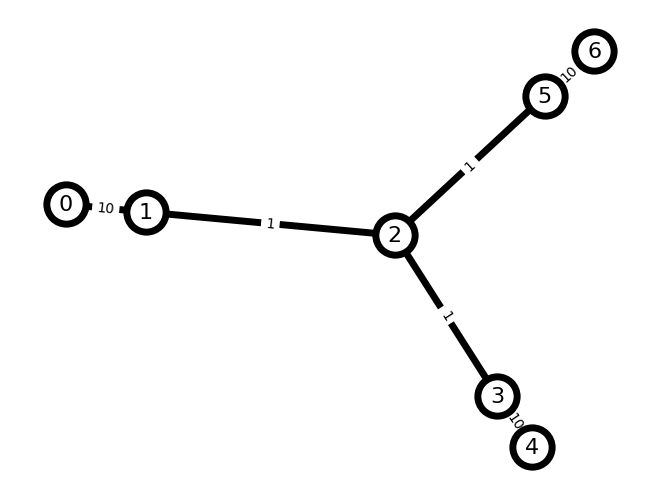

In [18]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (2,5, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch

In [19]:
find3WayCut(graph, [0,4,6])

2

# Generating Data
## Experiment 1

Creating training set with the following constraints:
- Each graph have precisey 30 nodes
- Each graph has random edges (50% edges connected)
- Each edge has random value of 1-10

In [20]:
datasetItem = {}
for i in range(1000):


    graph = CreateGraph(30)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, graph]

Number of edges: 231
Sample edges: [(0, 1, {'weight': 6, 'capacity': 6}), (0, 4, {'weight': 5, 'capacity': 5}), (0, 5, {'weight': 6, 'capacity': 6}), (0, 6, {'weight': 8, 'capacity': 8}), (0, 7, {'weight': 3, 'capacity': 3})]
Number of edges: 220
Sample edges: [(0, 1, {'weight': 4, 'capacity': 4}), (0, 5, {'weight': 4, 'capacity': 4}), (0, 6, {'weight': 4, 'capacity': 4}), (0, 9, {'weight': 3, 'capacity': 3}), (0, 12, {'weight': 7, 'capacity': 7})]
Number of edges: 228
Sample edges: [(0, 2, {'weight': 10, 'capacity': 10}), (0, 3, {'weight': 5, 'capacity': 5}), (0, 8, {'weight': 2, 'capacity': 2}), (0, 9, {'weight': 2, 'capacity': 2}), (0, 10, {'weight': 2, 'capacity': 2})]
Number of edges: 217
Sample edges: [(0, 4, {'weight': 4, 'capacity': 4}), (0, 5, {'weight': 5, 'capacity': 5}), (0, 6, {'weight': 2, 'capacity': 2}), (0, 7, {'weight': 7, 'capacity': 7}), (0, 9, {'weight': 2, 'capacity': 2})]
Number of edges: 196
Sample edges: [(0, 2, {'weight': 0, 'capacity': 0}), (0, 3, {'weight': 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


/Users/javaad/Documents/research/COP/lib/python3.10/site-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


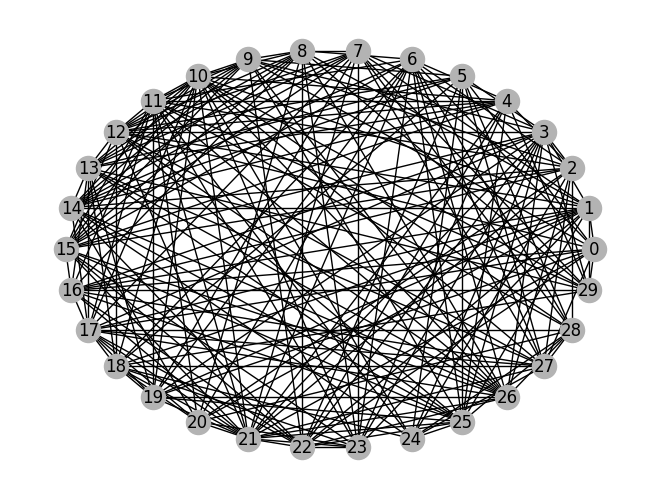

In [21]:
print(datasetItem[1][2].nodes)
# Visualize graph
pos = nx.kamada_kawai_layout(datasetItem[1][2])
nx.draw(datasetItem[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])

### Neural Network Training

In [22]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=30,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

terminal_nodes = 3

trained_net, bestLost, epoch, inp= run_gnn_training(
    datasetItem, net, embed, optimizer, int(1e1),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, terminal_nodes, 30, gnn_hypers['number_classes'], './exp1.pth')


Epoch: 0, Cumulative Loss: 2900887.2282714844
GNN training for 30 nodes took 14.317 seconds.
Best cumulative loss: 2577.641357421875


### Testing on exp1

In [31]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=30,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp1.pth')
model.eval()

#create dummy graph
graph = CreateGraph(20)
dgl_graph = dgl.from_networkx(nx_graph=graph)
dgl_graph = dgl_graph.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

# find min cut
print("Heurestic 3-way min-cut value: " + str(find3WayCut(graph, [0,16,19])))
print("Neural Network 3-way min-cut value: " + str(GetOptimalNetValue(model,dgl_graph, inputs, q_torch, {0:0, 16:1, 19:2})))


Number of edges: 101
Sample edges: [(0, 2, {'weight': 4, 'capacity': 4}), (0, 4, {'weight': 4, 'capacity': 4}), (0, 5, {'weight': 8, 'capacity': 8}), (0, 8, {'weight': 8, 'capacity': 8}), (0, 9, {'weight': 4, 'capacity': 4})]
Heurestic 3-way min-cut value: 117


RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x30 and 5x2)

In [11]:
test_item = {}
for i in range(10):


    graph = CreateGraph(30)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]

for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    print("Heurestic 3-way min-cut value: " + str(find3WayCut(graph, [0,20,28])))
    print("Neural Network 3-way min-cut value: " + str(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 20:1, 28:2})))
    print(f'-------')


Number of edges: 213
Sample edges: [(0, 2, {'weight': 10, 'capacity': 10}), (0, 6, {'weight': 3, 'capacity': 3}), (0, 7, {'weight': 6, 'capacity': 6}), (0, 8, {'weight': 4, 'capacity': 4}), (0, 10, {'weight': 3, 'capacity': 3})]
Number of edges: 207
Sample edges: [(0, 1, {'weight': 5, 'capacity': 5}), (0, 2, {'weight': 10, 'capacity': 10}), (0, 5, {'weight': 6, 'capacity': 6}), (0, 6, {'weight': 5, 'capacity': 5}), (0, 7, {'weight': 5, 'capacity': 5})]
Number of edges: 229
Sample edges: [(0, 3, {'weight': 5, 'capacity': 5}), (0, 6, {'weight': 1, 'capacity': 1}), (0, 8, {'weight': 4, 'capacity': 4}), (0, 13, {'weight': 7, 'capacity': 7}), (0, 14, {'weight': 5, 'capacity': 5})]
Number of edges: 226
Sample edges: [(0, 2, {'weight': 5, 'capacity': 5}), (0, 4, {'weight': 2, 'capacity': 2}), (0, 6, {'weight': 0, 'capacity': 0}), (0, 7, {'weight': 7, 'capacity': 7}), (0, 8, {'weight': 3, 'capacity': 3})]
Number of edges: 230
Sample edges: [(0, 2, {'weight': 6, 'capacity': 6}), (0, 3, {'weight

## Experiment 2

Creating training set with the following constraints:
- Each graph have precisey 100 nodes
- Each graph has random edges (50% probability of edge creation)
- Each edge has random value of 1-500

In [17]:
datasetItem = {}
for i in range(1000):


    graph = CreateGraph(100)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, graph]
    print("Graph Number Created: "+str(i))

Number of edges: 2481
Sample edges: [(0, 1, {'weight': 9, 'capacity': 9}), (0, 3, {'weight': 0, 'capacity': 0}), (0, 9, {'weight': 3, 'capacity': 3}), (0, 13, {'weight': 2, 'capacity': 2}), (0, 14, {'weight': 4, 'capacity': 4})]
Graph Number Created: 0
Number of edges: 2500
Sample edges: [(0, 4, {'weight': 6, 'capacity': 6}), (0, 5, {'weight': 3, 'capacity': 3}), (0, 7, {'weight': 0, 'capacity': 0}), (0, 8, {'weight': 6, 'capacity': 6}), (0, 9, {'weight': 1, 'capacity': 1})]
Graph Number Created: 1
Number of edges: 2507
Sample edges: [(0, 1, {'weight': 8, 'capacity': 8}), (0, 3, {'weight': 2, 'capacity': 2}), (0, 4, {'weight': 7, 'capacity': 7}), (0, 5, {'weight': 10, 'capacity': 10}), (0, 6, {'weight': 8, 'capacity': 8})]
Graph Number Created: 2
Number of edges: 2520
Sample edges: [(0, 2, {'weight': 7, 'capacity': 7}), (0, 3, {'weight': 2, 'capacity': 2}), (0, 4, {'weight': 7, 'capacity': 7}), (0, 6, {'weight': 6, 'capacity': 6}), (0, 7, {'weight': 2, 'capacity': 2})]
Graph Number Cre

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


/Users/javaad/Documents/research/COP/lib/python3.10/site-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


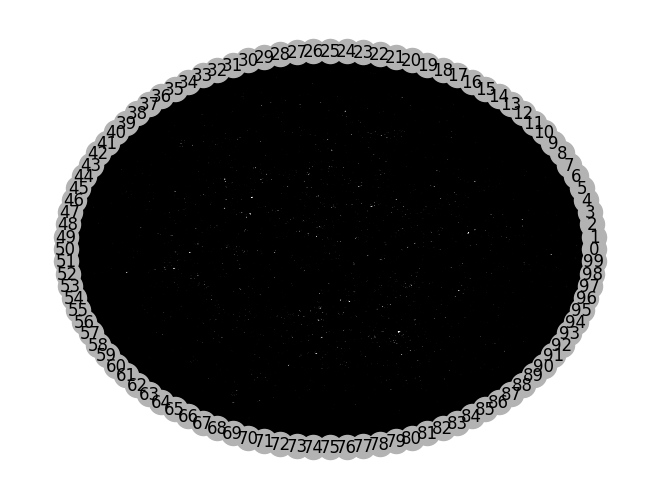

In [18]:
print(datasetItem[1][2].nodes)
# Visualize graph
pos = nx.kamada_kawai_layout(datasetItem[1][2])
nx.draw(datasetItem[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])

In [22]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

terminal_nodes = 3

trained_net, bestLost, epoch, inp= run_gnn_training(
    datasetItem, net, embed, optimizer, int(1e3),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, terminal_nodes, 100, gnn_hypers['number_classes'], './exp2.pth')


Epoch: 0, Cumulative Loss: 31301827.763671875
Epoch: 100, Cumulative Loss: 25250287.0
Epoch: 200, Cumulative Loss: 25250287.0
Epoch: 300, Cumulative Loss: 25250287.0
Epoch: 400, Cumulative Loss: 25250287.0
Epoch: 500, Cumulative Loss: 25250287.0
Epoch: 600, Cumulative Loss: 25250287.0
Epoch: 700, Cumulative Loss: 25250287.0
Epoch: 800, Cumulative Loss: 25250287.0
Epoch: 900, Cumulative Loss: 25250287.0
GNN training for 100 nodes took 1529.399 seconds.
Best cumulative loss: 24792.0


## Testing Exp2

In [24]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp2.pth')
model.eval()

#create dummy graph
graph = CreateGraph(100)
dgl_graph = dgl.from_networkx(nx_graph=graph)
dgl_graph = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

# find min cut
print("Heurestic 3-way min-cut value: " + str(find3WayCut(graph, [0,20,28])))
print("Neural Network 3-way min-cut value: " + str(GetOptimalNetValue(model,dgl_graph, inputs, q_torch, {0:0, 20:1, 28:2})))


Number of edges: 2445
Sample edges: [(0, 2, {'weight': 2, 'capacity': 2}), (0, 3, {'weight': 3, 'capacity': 3}), (0, 6, {'weight': 7, 'capacity': 7}), (0, 7, {'weight': 2, 'capacity': 2}), (0, 8, {'weight': 7, 'capacity': 7})]
Heurestic 3-way min-cut value: 472
Neural Network 3-way min-cut value: tensor(467., dtype=torch.float64)


In [59]:
test_item = {}
for i in range(100):


    graph = CreateGraph(100)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]

indices = []
i = 0
heurestic_cut = []
neural_cut = []
for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    heurestic_cut.append(find3WayCut(graph, [0,20,65]))
    neural_cut.append(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 20:1, 65:2}))
    i+=1
    indices.append(i)
    print("Heurestic 3-way min-cut value: " + str(heurestic_cut[-1]))
    print("Neural Network 3-way min-cut value: " + str(neural_cut[-1]))
    print(f'-------')

Number of edges: 2485
Sample edges: [(0, 2, {'weight': 3, 'capacity': 3}), (0, 5, {'weight': 10, 'capacity': 10}), (0, 6, {'weight': 7, 'capacity': 7}), (0, 7, {'weight': 9, 'capacity': 9}), (0, 9, {'weight': 5, 'capacity': 5})]
Number of edges: 2513
Sample edges: [(0, 1, {'weight': 8, 'capacity': 8}), (0, 3, {'weight': 4, 'capacity': 4}), (0, 5, {'weight': 1, 'capacity': 1}), (0, 6, {'weight': 1, 'capacity': 1}), (0, 9, {'weight': 10, 'capacity': 10})]
Number of edges: 2527
Sample edges: [(0, 2, {'weight': 0, 'capacity': 0}), (0, 3, {'weight': 3, 'capacity': 3}), (0, 4, {'weight': 10, 'capacity': 10}), (0, 5, {'weight': 2, 'capacity': 2}), (0, 7, {'weight': 8, 'capacity': 8})]
Number of edges: 2522
Sample edges: [(0, 1, {'weight': 3, 'capacity': 3}), (0, 2, {'weight': 0, 'capacity': 0}), (0, 3, {'weight': 9, 'capacity': 9}), (0, 4, {'weight': 3, 'capacity': 3}), (0, 5, {'weight': 5, 'capacity': 5})]
Number of edges: 2490
Sample edges: [(0, 1, {'weight': 1, 'capacity': 1}), (0, 3, {'we

In [71]:
# Function to plot True vs Prediction graph
def barPlot(indices, heurestic_cut, neural_cut):
    # Example data
    n_groups = len(heurestic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create bars
    plt.figure(figsize=(30, 6))
    bar1 = plt.bar(index, heurestic_cut, bar_width, label='Heurestic')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network')

    # Add details
    plt.xlabel('Graph Number')
    plt.ylabel('Minimum Cut Value')
    plt.title('Comparison of Minimum Cut Values by Algorithm')
    plt.xticks(index + bar_width / 2, range(1, n_groups + 1))
    plt.legend()
    plt.tight_layout()
    plt.show()

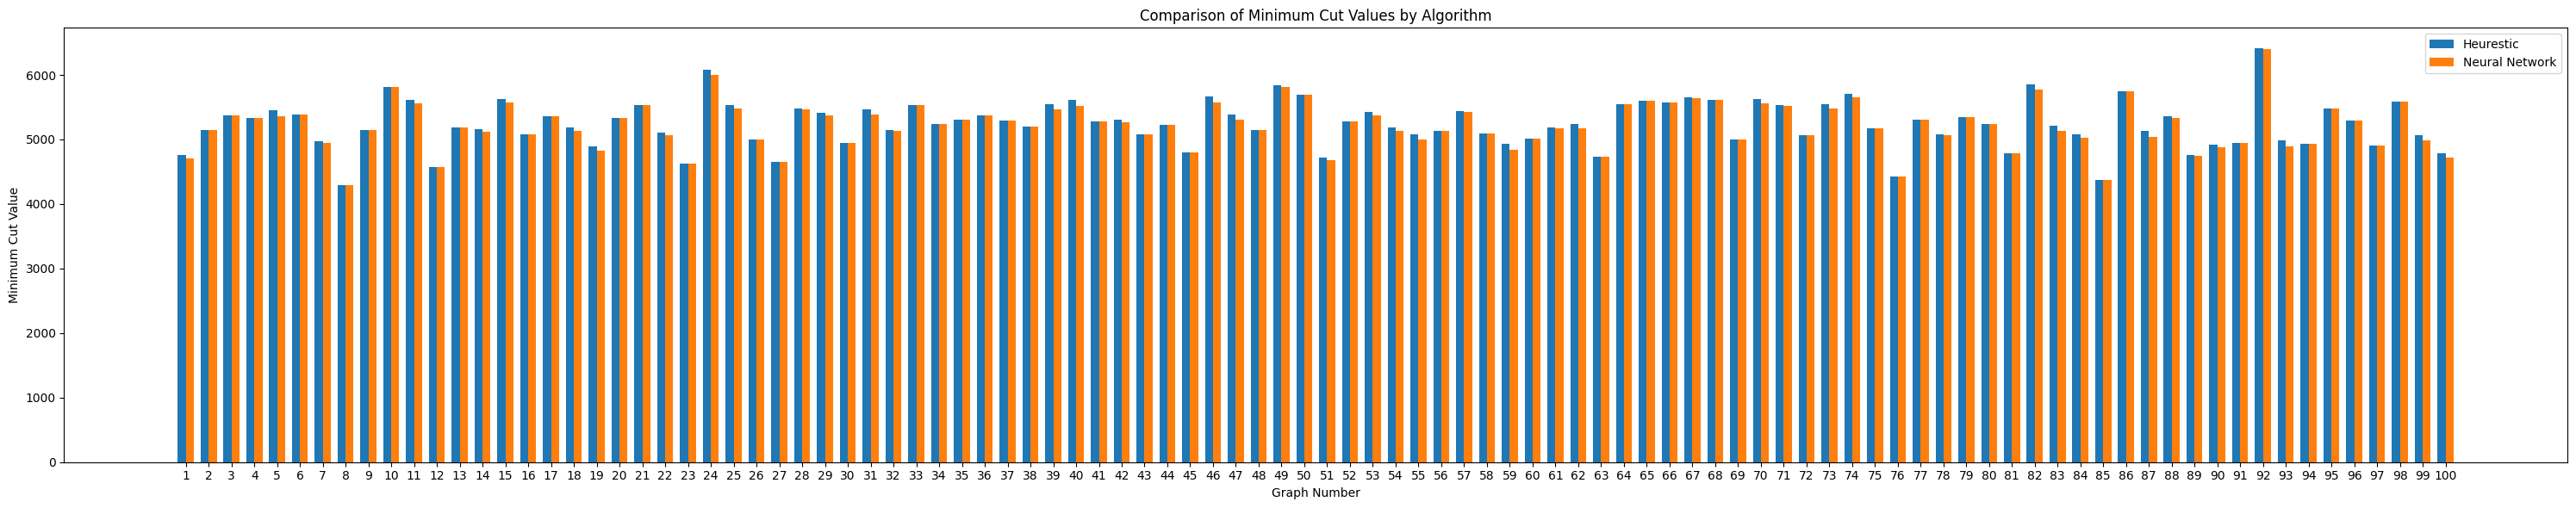

In [72]:
barPlot(indices, heurestic_cut, neural_cut)

In [63]:
percentage = 0
min_cut_value_less_than_heuristic = 0
for i in indices:
    if neural_cut[i-1] <= heurestic_cut[i-1]:
        percentage+=1
    if neural_cut[i-1] < heurestic_cut[i-1]:
        min_cut_value_less_than_heuristic+=1
print("Percentage better or equal min-cut value:" +  str(percentage))
print("Percentage better min-cut value:" +  str(min_cut_value_less_than_heuristic))

Percentage better or equal min-cut value:100
Percentage better min-cut value:43


In [64]:
test_item = {}
for i in range(100):


    graph = CreateGraph_random(100, 100)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]

indices = []
i = 0
heurestic_cut = []
neural_cut = []
for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    heurestic_cut.append(find3WayCut(graph, [0,20,65]))
    neural_cut.append(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 20:1, 65:2}))
    i+=1
    indices.append(i)
    print("Heurestic 3-way min-cut value: " + str(heurestic_cut[-1]))
    print("Neural Network 3-way min-cut value: " + str(neural_cut[-1]))
    print(f'-------')

Number of edges: 2715
Sample edges: [(0, 1, {'weight': 83, 'capacity': 83}), (0, 2, {'weight': 32, 'capacity': 32}), (0, 4, {'weight': 90, 'capacity': 90}), (0, 5, {'weight': 86, 'capacity': 86}), (0, 6, {'weight': 5, 'capacity': 5})]
Number of edges: 2741
Sample edges: [(0, 1, {'weight': 19, 'capacity': 19}), (0, 4, {'weight': 67, 'capacity': 67}), (0, 5, {'weight': 53, 'capacity': 53}), (0, 6, {'weight': 92, 'capacity': 92}), (0, 7, {'weight': 80, 'capacity': 80})]
Number of edges: 2707
Sample edges: [(0, 2, {'weight': 39, 'capacity': 39}), (0, 4, {'weight': 2, 'capacity': 2}), (0, 5, {'weight': 34, 'capacity': 34}), (0, 6, {'weight': 63, 'capacity': 63}), (0, 9, {'weight': 79, 'capacity': 79})]
Number of edges: 2736
Sample edges: [(0, 4, {'weight': 75, 'capacity': 75}), (0, 5, {'weight': 94, 'capacity': 94}), (0, 6, {'weight': 100, 'capacity': 100}), (0, 7, {'weight': 16, 'capacity': 16}), (0, 8, {'weight': 51, 'capacity': 51})]
Number of edges: 2760
Sample edges: [(0, 1, {'weight':

In [65]:
percentage = 0
min_cut_value_less_than_heuristic = 0
for i in indices:
    if neural_cut[i-1] <= heurestic_cut[i-1]:
        percentage+=1
    if neural_cut[i-1] < heurestic_cut[i-1]:
        min_cut_value_less_than_heuristic+=1
print("Percentage better or equal min-cut value:" +  str(percentage))
print("Percentage better min-cut value:" +  str(min_cut_value_less_than_heuristic))

Percentage better or equal min-cut value:100
Percentage better min-cut value:52


## Experiment 3

Creating training set with the following constraints:
- Each graph have precisely 300 nodes
- Each graph has random edges (50% probability of edge creation)
- Each edge has random value of 1-500

In [66]:
datasetItem = {}
for i in range(1000):


    graph = CreateGraph_random(300, 500)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, graph]
    print("Graph Number Created: "+str(i))

Number of edges: 24681
Sample edges: [(0, 1, {'weight': 268, 'capacity': 268}), (0, 2, {'weight': 243, 'capacity': 243}), (0, 3, {'weight': 151, 'capacity': 151}), (0, 4, {'weight': 320, 'capacity': 320}), (0, 7, {'weight': 471, 'capacity': 471})]
Graph Number Created: 0
Number of edges: 24707
Sample edges: [(0, 1, {'weight': 439, 'capacity': 439}), (0, 2, {'weight': 146, 'capacity': 146}), (0, 3, {'weight': 89, 'capacity': 89}), (0, 4, {'weight': 414, 'capacity': 414}), (0, 8, {'weight': 371, 'capacity': 371})]
Graph Number Created: 1
Number of edges: 24586
Sample edges: [(0, 2, {'weight': 74, 'capacity': 74}), (0, 4, {'weight': 277, 'capacity': 277}), (0, 5, {'weight': 424, 'capacity': 424}), (0, 6, {'weight': 112, 'capacity': 112}), (0, 8, {'weight': 318, 'capacity': 318})]
Graph Number Created: 2
Number of edges: 24764
Sample edges: [(0, 1, {'weight': 267, 'capacity': 267}), (0, 2, {'weight': 465, 'capacity': 465}), (0, 4, {'weight': 270, 'capacity': 270}), (0, 6, {'weight': 111, '

In [73]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=300,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

terminal_nodes = 3

trained_net, bestLost, epoch, inp= run_gnn_training(
    datasetItem, net, embed, optimizer, int(1e3),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, terminal_nodes, 300, gnn_hypers['number_classes'], './exp3.pth')


Epoch: 0, Cumulative Loss: 15038437497.0
Epoch: 100, Cumulative Loss: 12437632099.0
Epoch: 200, Cumulative Loss: 12437632099.0
Epoch: 300, Cumulative Loss: 12437632099.0
Epoch: 400, Cumulative Loss: 12437632099.0
Epoch: 500, Cumulative Loss: 12437632099.0
Epoch: 600, Cumulative Loss: 12437632099.0
Epoch: 700, Cumulative Loss: 12437632099.0
Epoch: 800, Cumulative Loss: 12437632099.0
Epoch: 900, Cumulative Loss: 12437632099.0
GNN training for 300 nodes took 4323.207 seconds.
Best cumulative loss: 12462551.0


In [74]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=300,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp3.pth')
model.eval()



GCNSoftmax(
  (conv1): GraphConv(in=17, out=8, normalization=both, activation=None)
  (conv2): GraphConv(in=8, out=3, normalization=both, activation=None)
)

In [75]:

test_item = {}
for i in range(100):


    graph = CreateGraph_random(300, 500)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]

indices = []
i = 0
heurestic_cut = []
neural_cut = []
for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    heurestic_cut.append(find3WayCut(graph, [0,150,250]))
    neural_cut.append(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 150:1, 250:2}))
    i+=1
    indices.append(i)
    print("Heurestic 3-way min-cut value: " + str(heurestic_cut[-1]))
    print("Neural Network 3-way min-cut value: " + str(neural_cut[-1]))
    print(f'-------')

Number of edges: 24777
Sample edges: [(0, 2, {'weight': 24, 'capacity': 24}), (0, 3, {'weight': 269, 'capacity': 269}), (0, 5, {'weight': 200, 'capacity': 200}), (0, 7, {'weight': 151, 'capacity': 151}), (0, 8, {'weight': 146, 'capacity': 146})]
Number of edges: 24583
Sample edges: [(0, 1, {'weight': 201, 'capacity': 201}), (0, 2, {'weight': 56, 'capacity': 56}), (0, 3, {'weight': 331, 'capacity': 331}), (0, 4, {'weight': 35, 'capacity': 35}), (0, 5, {'weight': 45, 'capacity': 45})]
Number of edges: 24462
Sample edges: [(0, 4, {'weight': 278, 'capacity': 278}), (0, 6, {'weight': 478, 'capacity': 478}), (0, 7, {'weight': 145, 'capacity': 145}), (0, 9, {'weight': 491, 'capacity': 491}), (0, 11, {'weight': 193, 'capacity': 193})]
Number of edges: 24607
Sample edges: [(0, 1, {'weight': 33, 'capacity': 33}), (0, 2, {'weight': 96, 'capacity': 96}), (0, 3, {'weight': 14, 'capacity': 14}), (0, 4, {'weight': 489, 'capacity': 489}), (0, 5, {'weight': 145, 'capacity': 145})]
Number of edges: 2464

In [76]:
percentage = 0
min_cut_value_less_than_heuristic = 0
for i in indices:
    if neural_cut[i-1] <= heurestic_cut[i-1]:
        percentage+=1
    if neural_cut[i-1] < heurestic_cut[i-1]:
        min_cut_value_less_than_heuristic+=1
print("Percentage better or equal min-cut value:" +  str(percentage))
print("Percentage better min-cut value:" +  str(min_cut_value_less_than_heuristic))

Percentage better or equal min-cut value:100
Percentage better min-cut value:53


In [78]:
from matplotlib.ticker import ScalarFormatter
def barPlot_2(heurestic_cut, neural_cut):
    # Example data
    n_groups = len(heurestic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create bars
    plt.figure(figsize=(30, 6))
    bar1 = plt.bar(index, heurestic_cut, bar_width, label='Heurestic', log=True)
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network', log=True)

    # Add details
    plt.xlabel('Graph Number')
    plt.ylabel('Minimum Cut Value')
    plt.title('Comparison of Minimum Cut Values by Algorithm')
    plt.xticks(index + bar_width / 2, range(1, n_groups + 1))
    plt.legend()
    plt.tight_layout()
    plt.gca().yaxis.set(major_formatter=ScalarFormatter(), minor_formatter=ScalarFormatter());
    plt.show()

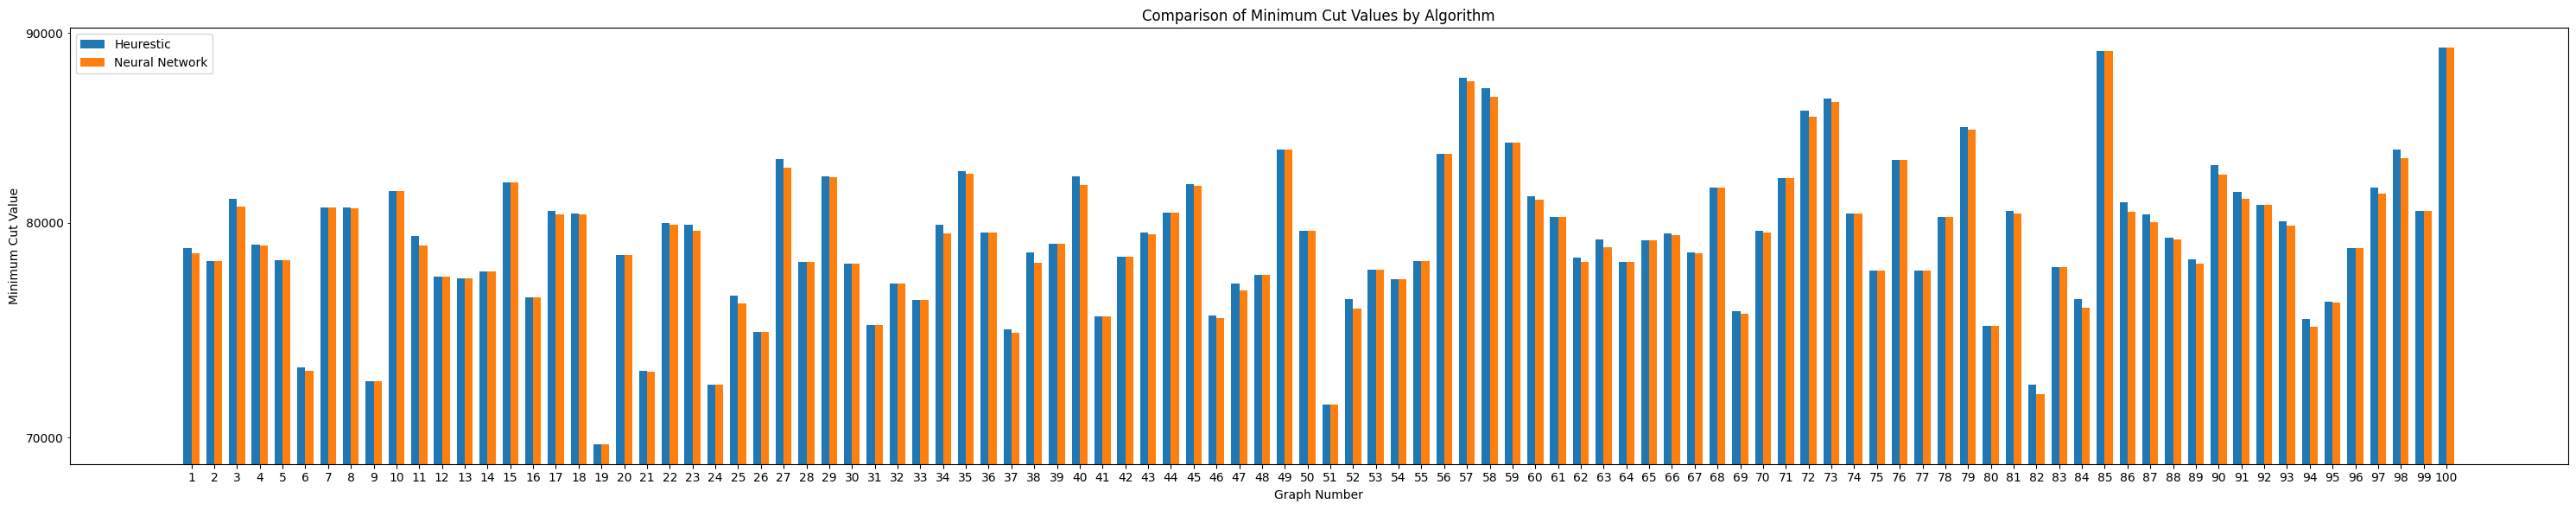

In [79]:
barPlot_2( heurestic_cut, neural_cut)